## Import

In [1]:
import os, re
import random, math
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import warnings 
warnings.filterwarnings(action='ignore')

## Setting

In [2]:
# 데이터 로드할 때 빠르게 로드할 수 있도록하는 설정 변수
AUTOTUNE = tf.data.experimental.AUTOTUNE
# X-RAY 이미지 사이즈 변수
IMAGE_SIZE = [180, 180]

# 데이터 경로 변수
ROOT_PATH = os.path.join(os.getenv('HOME'), 'aiffel') # HOME 폴더에 있는 aiffel 폴더로 가자
TRAIN_PATH = ROOT_PATH + '/chest_xray/data/train/*/*' # *은 모든 디렉토리와 파일을 의미합니다.
VAL_PATH = ROOT_PATH + '/chest_xray/data/val/*/*'
TEST_PATH = ROOT_PATH + '/chest_xray/data/test/*/*'


# 프로젝트를 진행할 때 아래 두 변수를 변경해보세요

# X-RAY 이미지 사이즈 변수
BATCH_SIZE = 16
# EPOCH 크기 변수
EPOCHS = 20



print(ROOT_PATH)

/aiffel/aiffel


## Dataset

In [3]:
# filenames = tf.io.gfile.glob(TRAIN_PATH)
# TRAIN_PATH에 있는 파일을 filenames 에 담자.

train_filenames = tf.io.gfile.glob(TRAIN_PATH)
test_filenames = tf.io.gfile.glob(TEST_PATH)
val_filenames = tf.io.gfile.glob(VAL_PATH)

print(len(train_filenames))
print(len(test_filenames))
print(len(val_filenames))


# 결론
#train 안에는 5216개, test 안에는 624개, val 안에는 16개가 있습니다.
#개수 비는 89%, 10.7%, 0.3% 입니다. val 개수가 너무 없기 때문에 train에서 val에 쓰일 데이터를 더 가져와보겠습니다.

5216
624
16


## Preprocess

In [4]:
# train과 val에 있는 데이터를 모은 다음에 train : val를 80:20으로 분할하겠습니다.
        
# train 데이터와 validation 데이터를 모두 filenames에 담습니다
filenames = tf.io.gfile.glob(TRAIN_PATH)
filenames.extend(tf.io.gfile.glob(VAL_PATH))

# 모아진 filenames를 8:2로 나눕니다
train_size = math.floor(len(filenames)*0.8) # math.floor(): 실수 범위를 자연수의 범위로 좁히기 위해 '내림'
random.seed(8) # random은 무작위, seed는 무작위의 결과를 특정한 값으로 고정하겠다는 뜻.
random.shuffle(filenames) # random.shuffle(): 원소들을 무작위로 셔플하여 섞어주는 함수
train_filenames = filenames[:train_size]
val_filenames = filenames[train_size:]

print(len(train_filenames))
print(len(val_filenames))

#이제 train은 4185개, test는 624개, val은 1047개가 되었습니다. test_size를 수정하면 개수는 달라질 수 있습니다.

4185
1047


In [31]:
#정상 이미지와 폐렴 이미지를 구분해야 하는데 다행히도 파일 경로에 힌트가 있네요

print(f'Normal image path\n{filenames[0]}')
print(f'Pneumonia image path\n{filenames[2000]}')

# 파일 경로에 Normal인지 Pneumonia인지 나와있는 예시를 보여주려고 하는것이다.
# 데이터셋에 레이블이 없으니까 나중에 레이블 만들 때 쓰려고 확인한 거 같아요
# 0이랑 2000은 그냥 임의로 지정한 숫자인것같습니당
# 랜덤 인덱스를 쓰긴했는데 0이 정상이고 2000이 폐렴인지를 미리 알고 그렇게 코드 짜신거 같긴하네요 ㅎㅎ

Normal image path
/aiffel/aiffel/chest_xray/data/train/NORMAL/NORMAL2-IM-1317-0001.jpeg
Pneumonia image path
/aiffel/aiffel/chest_xray/data/train/PNEUMONIA/person299_bacteria_1418.jpeg


In [33]:
# 이제 파일 경로에 NORMAL이 있는지 확인하면 정상 이미지를 셀 수 있습니다. 또한, 파일 경로에 PNEUMONIA이 있는지 확인하면 폐렴 이미지도 셀 수 있습니다.

COUNT_NORMAL = len([filename 
                    for filename in train_filenames 
                        if "NORMAL" in filename]) # for문, if 문을 사용하고 있지만, 한 줄로 쓸때는 콜론(:) 안들어가요
print(f"Normal images count in training set: {COUNT_NORMAL}")


COUNT_PNEUMONIA = len([filename 
                       for filename in train_filenames 
                           if "PNEUMONIA" in filename])
print(f"Pneumonia images count in training set: {COUNT_PNEUMONIA}")

# 결과를 보면 정상보다 폐렴 이미지 수가 3배 더 많이 있습니다. 
# 우리가 사용할 CNN 모델의 경우 데이터가 클래스별 balance가 좋을수록 training을 잘 합니다. 
# 데이터가 클래스 불균형(imbalance)한 것은 차후에 조정할 예정입니다. 
# (test와 val 데이터셋은 평가하기 위해서 사용되기 때문에 학습과 관련이 없으므로 imbalance한 데이터 셋이어도 문제없습니다.)

Normal images count in training set: 1072
Pneumonia images count in training set: 3113


In [7]:
# tf.data 인스턴스(객체)를 만들어 봅시다. tf.data는 tensorflow에서 학습시킬 때, mini-batch로 작업할 수 있도록 해 줍니다.

train_list_ds = tf.data.Dataset.from_tensor_slices(train_filenames) # tf.data.Dataset.from_tensor_slices 함수는 tf.data.Dataset 를 생성하는 함수로 입력된 텐서로부터 slices를 생성합니다

val_list_ds = tf.data.Dataset.from_tensor_slices(val_filenames)

# 데이터를 입력할때 모델이 다 못받아 들이기 때문에, 모델이 받아 들일 수 있는 형태로 가공을 하기 위함. 가공하는 방식 = mini-batch.

In [8]:
# Train 데이터셋, validation 데이터셋 개수 확인을 해보겠습니다.

TRAIN_IMG_COUNT = tf.data.experimental.cardinality(train_list_ds).numpy()
print(f"Training images count: {TRAIN_IMG_COUNT}")

VAL_IMG_COUNT = tf.data.experimental.cardinality(val_list_ds).numpy()
print(f"Validating images count: {VAL_IMG_COUNT}")

Training images count: 4185
Validating images count: 1047


In [9]:
# 현재 이미지에는 라벨 데이터가 따로 없습니다.
# 파일 경로에 'NORMAL'이나 'PNEUMONIA'가 포함되어 있기 때문에 이를 이용해서 라벨 데이터를 만들어 주는 함수를 만들어 보겠습니다.

# 파일 경로의 끝에서 두번째 부분을 확인하면 양성과 음성을 구분할 수 있습니다
def get_label(file_path):
    parts = tf.strings.split(file_path, os.path.sep)
    return parts[-2] == "PNEUMONIA"   # 폐렴이면 양성(True), 노말이면 음성(False)

In [10]:
# 이미지를 알맞은 형식으로 바꿉니다.
def decode_img(img):
    img = tf.image.decode_jpeg(img, channels=3) # 이미지를 uint8 tensor로 수정
    img = tf.image.convert_image_dtype(img, tf.float32) # float32 타입으로 수정
    img = tf.image.resize(img, IMAGE_SIZE) # 이미지 사이즈를 IMAGE_SIZE로 수정
    return img

# 이미지 파일의 경로를 입력하면 이미지와 라벨을 읽어옵니다.
def process_path(file_path):
    label = get_label(file_path) # 라벨 검출
    img = tf.io.read_file(file_path) # 이미지 읽기
    img = decode_img(img) # 이미지를 알맞은 형식으로 수정
    return img, label

In [11]:
# train 데이터 셋과 validation 데이터 셋을 만듭니다. 
train_ds = train_list_ds.map(process_path, num_parallel_calls=AUTOTUNE) # num_parallel_calls 파라미터에 위에서 할당한 AUTOTUNE변수를 이용하면 더욱 빠르게 데이터를 처리해 즐 수 있습니다.

val_ds = val_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)

In [12]:
# 이미지가 잘 리사이즈 되었는지, 그리고 라벨이 잘 들어가 있는지 확인해봅시다.

for image, label in train_ds.take(1): #  train_ds.take(1)은 하나의 데이터만 가져온다는 의미입니다.
    print("Image shape: ", image.numpy().shape)
    print("Label: ", label.numpy())

Image shape:  (180, 180, 3)
Label:  False


In [13]:
# 위에서 train과 validation 데이터셋을 만든 것처럼 test 데이터셋도 만들어 보겠습니다. 그리고 데이터 개수도 확인해보겠습니다.

test_list_ds = tf.data.Dataset.list_files(TEST_PATH)
TEST_IMAGE_COUNT = tf.data.experimental.cardinality(test_list_ds).numpy()
test_ds = test_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
test_ds = test_ds.batch(BATCH_SIZE)

print(TEST_IMAGE_COUNT)

624


In [14]:
def prepare_for_training(ds, shuffle_buffer_size=1000):
    # tf.data 파이프라인을 이용하여 prepare_for_training() 함수를 정의해서 데이터를 변환시켜주겠습니다.
    ds = ds.shuffle(buffer_size=shuffle_buffer_size) 
    # shuffle()을 사용하며 고정 크기 버퍼를 유지하고 해당 버퍼에서 무작위로 균일하게 다음 요소를 선택합니다.
    ds = ds.repeat() 
    # repeat()를 사용하면 epoch를 진행하면서 여러 번 데이터셋을 불러오게 되는데, 이때 repeat()를 사용한 데이터셋의 경우 여러 번 데이터셋을 사용할 수 있게 해줍니다
    # 예를 들어, 100개의 데이터를 10번 반복하면 1000개의 데이터가 필요하게 됩니다. repeat()를 사용하면 자동으로 데이터를 맞춰줍니다.
    ds = ds.batch(BATCH_SIZE) 
    # batch()를 사용하면 BATCH_SIZE에서 정한 만큼의 배치로 주어집니다.예를 들어, 100개의 데이터를 10개의 배치로 나누게 되면 각 배치에는 10개의 데이터로 나뉘게 됩니다.
    ds = ds.prefetch(buffer_size=AUTOTUNE) 
    # prefetch()를 사용하면 학습 데이터를 나눠서 읽어오기 때문에, 첫 번째 데이터를 GPU에서 학습하는 동안 두 번째 데이터를 CPU에서 준비할 수 있어 리소스의 유휴 상태를 줄일 수 있습니다.
    return ds

train_ds = prepare_for_training(train_ds)
val_ds = prepare_for_training(val_ds)

### 데이터 시각화

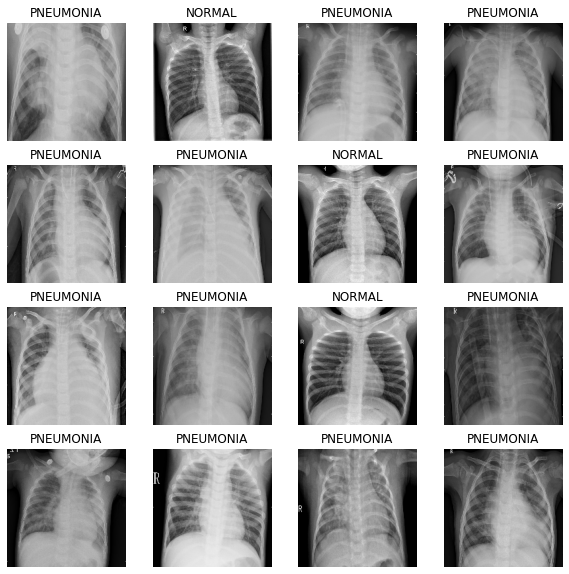

In [15]:
# 데이터를 보기 위해 먼저, train에 있는 batch 중 첫 번째 배치를 추출합니다. 추출된 배치를 image와 label 데이터 셋으로 나눕니다.

# 이미지 배치를 입력하면 여러장의 이미지를 보여줍니다.
def show_batch(image_batch, label_batch):
    plt.figure(figsize=(10,10))
    for n in range(BATCH_SIZE):
        ax = plt.subplot(4,math.ceil(BATCH_SIZE/4),n+1)
        plt.imshow(image_batch[n])
        if label_batch[n]:
            plt.title("PNEUMONIA")
        else:
            plt.title("NORMAL")
        plt.axis("off")


image_batch, label_batch = next(iter(train_ds))
show_batch(image_batch.numpy(), label_batch.numpy())
# show_batch() 함수를 이용해서 결과 사진을 보겠습니다.

### CNN 모델링

이미지 처리에 특화된 딥러닝 모델인 CNN을 통해 모델링을 하고 결과를 만들어 보겠습니다.

In [16]:
# 먼저, Convolution block을 만듭니다.

def conv_block(filters):
    # conv_block()의 구성은 Convolution을 두 번 진행하고 Batch Normalization을 통해서 Gradient vanishing, Gradient Exploding을 해결합니다. 그리고 Max Pooling을 합니다.
    block = tf.keras.Sequential([
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPool2D()
    ])
    
    return block

In [17]:
# Dense Block은 아래와 같이 만듭니다.

def dense_block(units, dropout_rate):
    block = tf.keras.Sequential([
        tf.keras.layers.Dense(units, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(dropout_rate)
        #  Batch Normalization과 Dropout이라는 두 가지 regularization 기법이 동시에 사용되고 있습니다
        # 이번 실습에서는 두 가지를 함께 사용하는 이 모델이 성능 향상에 도움이 될지 여부도 흥미롭게 살펴볼만 한 부분입니다.
    ])
    
    return block

# 우리가 만들 CNN 모델은 약간의 수정을 거쳐 만들어진 모델입니다. 전형적인 CNN 모델과는 약간 다른 모델입니다.

In [18]:
def build_model():
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)),
        
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.MaxPool2D(),
        
        conv_block(32),
        conv_block(64),
        
        conv_block(128),
        tf.keras.layers.Dropout(0.2),
        
        conv_block(256),
        tf.keras.layers.Dropout(0.2),
        
        tf.keras.layers.Flatten(),
        dense_block(512, 0.7),
        dense_block(128, 0.5),
        dense_block(64, 0.3),
        
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    
    return model

### 데이터 imbalance 처리

'Normal'과 폐렴에서 'Pneumonia' 중에 'Pneumonia' 데이터가 많이 있었죠? 한 라벨이 너무 많은 경우를 imbalance 하다고 하는데, 데이터를 학습할 때 imbalance한 데이터의 경우 학습 효과가 좋지 않을 수 있습니다.

이런 문제들을 해결하는 방법으로 Weight balancing이라는 테크닉이 사용됩니다. Weight balancing 은 training set의 각 데이터에서 loss를 계산할 때 특정 클래스의 데이터에 더 큰 loss 값을 갖도록 가중치를 부여하는 방법입니다.

In [19]:
# weight_for_0은 'Normal' 이미지에 사용할 weight를
weight_for_0 = (1 / COUNT_NORMAL)*(TRAIN_IMG_COUNT)/2.0 
# weight_for_1은 'Pneumonia' 이미지에 사용할 weight를 세팅
weight_for_1 = (1 / COUNT_PNEUMONIA)*(TRAIN_IMG_COUNT)/2.0
# 이 weight들은 'Normal'과 'Pneumonia' 전체 데이터 건수에 반비례하도록 설정됩니다.



class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for NORMAL: {:.2f}'.format(weight_for_0))
print('Weight for PNEUMONIA: {:.2f}'.format(weight_for_1))

Weight for NORMAL: 1.95
Weight for PNEUMONIA: 0.67


### 모델 훈련

In [20]:
with tf.device('/GPU:0'):
    # 이미지 훈련은 GPU를 사용할 것이기 때문에 먼저 GPU를 선택합니다. 
    model = build_model()
    # 모델은 위에서 만들었던 모델 함수인 build_model()을 model에 선언합니다.

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    # 성과에 대해서 측정하기 위한 metrics으로 'accuracy', 'precision', 'recall'을 사용합니다.
    
    model.compile(
        optimizer='adam',
        # optimizer로 'adam'을 사용합니다.
        loss='binary_crossentropy',
        # 이미지의 라벨이 두 개밖에 없기 때문에 "binary_cross entropy" loss를 사용합니다
        metrics=METRICS
        # 성과에 대해서 측정하기 위한 metrics으로 'accuracy', 'precision', 'recall'을 사용합니다.
    )

In [21]:
# 모델을 fit 해보겠습니다

# 각 파라미터에 위에서 선언했었던 변수, 데이터 셋을 가져와서 각각에 맞게 넣어줍니다. (모델 학습시 약 20분 이상 소요 됩니다.)


with tf.device('/GPU:0'):
    history = model.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
    )

Epoch 1/20
261/261 [==============================] - 84s 193ms/step - loss: 0.3823 - accuracy: 0.8072 - precision: 0.9520 - recall: 0.7800 - val_loss: 0.6431 - val_accuracy: 0.7337 - val_precision: 0.7337 - val_recall: 1.0000
Epoch 2/20
261/261 [==============================] - 50s 191ms/step - loss: 0.2292 - accuracy: 0.9148 - precision: 0.9728 - recall: 0.9108 - val_loss: 1.1040 - val_accuracy: 0.7356 - val_precision: 0.7356 - val_recall: 1.0000
Epoch 3/20
261/261 [==============================] - 51s 194ms/step - loss: 0.2098 - accuracy: 0.9143 - precision: 0.9718 - recall: 0.9111 - val_loss: 1.3241 - val_accuracy: 0.7346 - val_precision: 0.7346 - val_recall: 1.0000
Epoch 4/20
261/261 [==============================] - 51s 194ms/step - loss: 0.1929 - accuracy: 0.9258 - precision: 0.9755 - recall: 0.9234 - val_loss: 0.3456 - val_accuracy: 0.8308 - val_precision: 0.8132 - val_recall: 1.0000
Epoch 5/20
261/261 [==============================] - 52s 200ms/step - loss: 0.1709 - accura

### 결과 확인

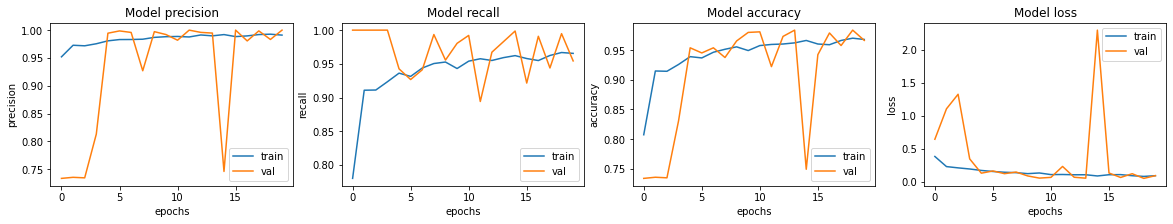

In [22]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])
    
# 그래프로 Epochs 마다 모델의 precision, recall, accuracy, loss가 어떻게 변하는지 보여줍니다.

In [23]:
# 테스트 데이터로 모델 평가를 해보겠습니다.

loss, accuracy, precision, recall = model.evaluate(test_ds)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

# 모델 평가를 위해 loss, accuracy, precision, recall 값을 출력해보겠습니다.

39/39 [==============================] - 5s 110ms/step - loss: 0.6286 - accuracy: 0.8173 - precision: 0.7816 - recall: 0.9821
Loss: 0.6285682320594788,
Accuracy: 0.817307710647583,
Precision: 0.781632661819458,
Recall: 0.9820512533187866


# [회고]

epoch 값을 여러가지로 변경해보아서 시도를 해보았으나, 0.85 이상이 나오는 것은 끝내 이루지 못하였다.
epoch 값이 커지면 더 좋은 성능이 나올 줄 알았는데, 오히려 0.6 점대로 떨어지는 것을 보고, epoch 가 높다고 무조건 좋은 것은 아니라는 것을 알게되었다.
또한 팀원들과 상의를 하면서, 사진을 좌우 반전 하는 경우, 성능이 좋아질것을 예상했으나, 반대로 성능이 급격히 떨어졌다는 후기를 알게 되었다.